# Cost and Processing-Time Prediction for Parallel Matrix Operations

In [155]:
import math
from collections import namedtuple
import matplotlib.pyplot as plt
import numpy as np

In [7]:
MatrixDimensions = namedtuple('MatrixDimensions', ['height', 'width'])

### Lambda Cost

In [105]:
# lambda cost
price_per_request = 0.0000002 # in $
price_per_GBs = 0.00001667 # in $

# Average Execution Times
intermediate_exec_time = { '1000': 2500, '2000':  14000 } 
collect_exec_time = { '1000': 3900,'2000': 13000 }
accumulate_exec_time = {'1000': 2000,'2000': 6700 }

In [56]:
def lambda_execution_cost(milliseconds, memory):
    price_per_GBs = 0.00001667 # in $
    ms_rounded_up = (math.ceil(milliseconds/100.0))*100.0
    return ms_rounded_up * memory * price_per_GBs/1024.0

In [71]:
def execution_time(splits, units_per_split, blocksize):
    units = splits * units_per_split
    intermediates = 7
    collectors = 1
    
    intermediate_time = units * intermediates * intermediate_exec_time[str(blocksize)]
    collector_time = units * collectors * collect_exec_time[str(blocksize)]
    accumulator_time = units * accumulators_per_split * accumulate_exec_time[str(blocksize)]

    return  intermediate_time + collector_time + accumulator_time

In [ ]:
execution_cost(170.0, 1536.0)

### StepFunction Cost

In [122]:
price_per_transition = 0.000025 # in $

TRANSITIONS_PER_UNIT_OLD = 2 + 14 + 1
# 2 in/out of unit-pass, 7 intermediates, 1 collector
TRANSITIONS_PER_UNIT = 2 + 7 + 1
ACCUMULATORS_PER_SPLIT = 1

In [127]:
def transitions_for_split_with(units):
    start = 1 # transition to surrounding parallel state
    unit_transitions = units * TRANSITIONS_PER_UNIT
    accumulators = 1
    accumulate_transitions = ACCUMULATORS_PER_SPLIT * 2 # in and out of accum.
    return start + unit_transitions + accumulate_transitions

In [21]:
units = 2
transitions_for_split_with(units)

23

### S3 cost

In [10]:
price_per_put_request =  0.01 /  1000.0 # in $
price_per_get_request = 0.001 / 10000.0 # in $

In [146]:
# multipart uploads
kB = 1024
MB = kB * kB
multipart_threshold = 8 * MB
multipart_chunksize = 8 * MB

from collections import OrderedDict
blocksizes_in_MB = OrderedDict{ 1000: 7.6, 2000: 30.5 , 3000: 72.0, 4000: 128.0, 5000: 200.0, 6000: 288.0, 7000: 392.0, 8000: 512.0 }

In [180]:
x = np.array([ x**2 * 2 for x in sorted(blocksizes_in_MB.keys())])
y = np.array(sorted(blocksizes_in_MB.values()))
z = np.polyfit(x, y, 1)
print z
n = 1000**2 * 2
print z[0]*n + z[1]

[  4.00588936e-06  -5.37857143e-01]
7.47392156863


[2000000, 8000000, 18000000, 32000000, 50000000, 72000000, 98000000, 128000000]
[30.5, 72.0, 200.0, 128.0, 392.0, 7.6, 512.0, 288.0]


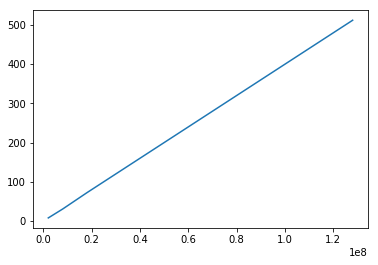

In [181]:
print sorted(x)
print blocksizes_in_MB.values()
plt.plot(x, sorted(blocksizes_in_MB.values()))
plt.show()

In [141]:
def estimate_puts(splits, units_per_split):
    uploads_per_intermediate = 1
    uploads_per_collector = 4
    uploads_per_accumulator = 4
    
    intermediate_uploads = uploads_per_intermediate * 7 * splits * units_per_split
    collector_uploads = uploads_per_collector * splits * units_per_split
    accumulators_uploads = uploads_per_collector * splits
    
    return intermediate_uploads + collector_uploads + accumulators_uploads
    

def estimate_gets(splits, units_per_split):
    downloads_per_intermediate = (4 * 3 + 3 * 4) / 7 # = 3,43 downloads on average
    downloads_per_collector = 12
    downloads_per_accumulator = 4 * units_per_split
    
    intermediate_downloads = downloads_per_intermediate * units_per_split * splits
    collector_downloads = downloads_per_collector * units_per_split * splits
    accumulators_downloads = downloads_per_accumulator * splits

    return intermediate_downloads + collector_downloads + accumulators_downloads

In [92]:
def s3_request_cost(puts, gets, data_transfered_in_MB):
    data_transfer_cost = data_transfered_in_MB * 0.01/1024
    put_cost = puts * price_per_put_request
    get_cost = gets * price_per_get_request
    return data_transfer_cost + put_cost + get_cost

### Total Cost

In [ ]:
def operational_cost(transitions, execution_time, memory, transfered_data):
    lambda_cost = lambda_execution_cost + lambda_request_cost
    stepfunction_cost = transitions * price_per_transition
    s3_cost = s3_requests + s3_storage_cost + transfer_cost
    return lambda_cost + stepfunction_cost + s3_cost

In [118]:
def calculate_cost(matA, matB, blocksize=2000):
    splitsize = blocksize * 2
    
    # Values
    m = matrixA.height
    n = matrixA.width
    p = matrixB.width
    
    units_per_split = n / splitsize
    splits = m/splitsize * p/splitsize
    
    print 'Units per split: ', units_per_split
    print 'Splits: ', splits
    print 'Units total:' , units_per_split * splits
    
    print '\nCost division'
    
    lmbd = calculate_lambda_cost(splits, units_per_split, blocksize)
    print 'Lambda cost: $', lmbd
    sfn = calculate_stepfunction_cost(splits, units_per_split)
    print 'StepFunction cost: $', sfn
    s3 = calculate_s3_cost(splits, units_per_split)
    print 'S3 cost: $', s3
            
    print '------\nTotal: $', lmbd + s3 + sfn
    return lmbd + s3 + sfn

def calculate_lambda_cost(splits, units_per_split, blocksize):
    exec_time = execution_time(splits, units_per_split, blocksize)
    exec_cost = lambda_execution_cost(milliseconds=exec_time, memory=1024)
    request_cost = 0
    return exec_cost + request_cost

def calculate_stepfunction_cost(splits, units_per_split):
    transitions = splits * transitions_for_split_with(units_per_split) 
    return transitions * price_per_transition

def calculate_s3_cost(splits, units_per_split):
    puts=estimate_puts(splits, units_per_split)
    gets=estimate_gets(splits, units_per_split)
    return s3_request_cost(puts, gets, data_transfered_in_MB=0)

In [128]:
calculate_cost(MatrixDimensions(height=8000, width=8000), MatrixDimensions(height=8000, width=8000), blocksize=2000)

Units per split:  2
Splits:  4
Units total: 8

Cost division
Lambda cost: $ 15.696472
StepFunction cost: $ 0.0023
S3 cost: $ 0.0010552
------
Total: $ 15.6998272


15.699827200000001

In [129]:
calculate_cost(MatrixDimensions(height=8000, width=8000), MatrixDimensions(height=8000, width=8000), blocksize=1000)

Units per split:  4
Splits:  16
Units total: 64

Cost division
Lambda cost: $ 24.964992
StepFunction cost: $ 0.0172
S3 cost: $ 0.0078016
------
Total: $ 24.9899936


24.989993600000002

In [130]:
calculate_cost(MatrixDimensions(height=4000, width=4000), MatrixDimensions(height=4000, width=4000), blocksize=1000)

Units per split:  4
Splits:  16
Units total: 64

Cost division
Lambda cost: $ 24.964992
StepFunction cost: $ 0.0172
S3 cost: $ 0.0078016
------
Total: $ 24.9899936


24.989993600000002

In [ ]:
def plot_total_time_vs_total_cost_prediction():
    # as a function of blocksize for a fixed Matrix Multiplication (e.g. 8k*8k)
    